<a href="https://colab.research.google.com/github/guilherminog/Desafios-DNC/blob/main/Desafio7_Guilhermino_Gomes_Luis_Junior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafio de Clusterização
## Criação de um modelo de Clusterização para clientes de uma empresa de e-commerce








# Modelo de Clustering para Agrupamento de Perfis de Clientes em um E-commerce

### Problemática do desafio

Você foi contratado por uma empresa de e-commerce que está buscando entender melhor o comportamento de seus clientes para personalizar as suas campanhas de marketing. Para isso, a empresa disponibilizou uma base de dados em CSV contendo dados sobre clientes, produtos e transações da loja realizadas entre os anos de 2010 e 2011.

Com base nesses dados, você precisa agrupar os clientes em clusters com base em seu comportamento de compra. Isso irá permitir identificar padrões e características em comum entre os clientes, como:

- Clientes que compram os mesmos produtos;
- Clientes que possuem a mesma frequência de compras;
- Clientes que gastam mais dinheiro em suas compras.

A partir desses clusters, gere insights para que a empresa possa segmentar melhor a sua base de clientes e personalizar as suas campanhas de marketing, direcionando promoções e ofertas aos clientes com base no comportamento de compras.

## Sobre os Dados

Acesse os dados aqui: [Dataset E-commerce](https://www.kaggle.com/datasets/carrie1/ecommerce-data)

Os dados fornecidos possuem informações de transações de compras de uma loja de e-commerce em 38 países e territórios, com mais de 4.000 clientes únicos e mais de 540.000 transações.

### Tabela de Dados

| Coluna       | Descrição                                               | Tipo    |
|--------------|--------------------------------------------------------|---------|
| InvoiceNo    | Identificação da transação                             | Int     |
| StockCode    | Código de estoque do produto                           | String  |
| Description  | Descrição do produto                                   | String  |
| Quantity     | Quantidade de produtos por transação                   | Int     |
| InvoiceDate  | Data da transação                                      | Datetime|
| UnitPrice    | Preço unitário do produto                              | Float   |
| CustomerID   | Identificação do cliente                               | Int     |
| Country      | País de origem da transação                            | String  |

### Import bibliotecas

In [1]:
# Análise de dados
import pandas as pd
import numpy as np

# Ferramentas de visualização
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from yellowbrick.cluster import kelbow_visualizer
sns.set_theme()

# Pré processamento
from sklearn.preprocessing import StandardScaler

# Modelos de Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, estimate_bandwidth
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
import scipy.cluster.hierarchy as sch
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA


In [2]:
def describe_df(df):
    describe = pd.concat(
        [
            df.describe(
                include='all'
            ).T.round(
                decimals=3
            ),
            pd.DataFrame(
                (
                    (
                        df.isna().sum() / df.shape[0]
                    ) * 100
                ).round(
                    decimals=3
                ),
                columns = ['pct_nulls']
            )
        ],
        axis=1
    )
    return describe

### Importar base de dados
Se ocorrer erro de **UnicoreDecodeError**, testar diferentes métodos de *encoding* para conseguir ler o arquivo.

In [3]:
transactions = pd.read_csv('/content/data (2).csv', encoding='iso-8859-1')

transactions.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
transactions.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


### Análise descritiva dos dados

In [5]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
cat = ['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Country']
num = ['Quantity', 'UnitPrice', 'InvoiceDate']

In [8]:
transactions['InvoiceDate'] = pd.to_datetime(transactions['InvoiceDate'], dayfirst=False)
transactions['CustomerID'] = transactions['CustomerID'].astype('Int64')

Verificar a distribuição dos dados

In [9]:
describe_df(transactions)

,count,unique,top,freq,mean,min,25%,50%,75%,max,std,pct_nulls
InvoiceNo,541909,25900,573585,1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
StockCode,541909,4070,85123A,2313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.268
Quantity,541909.0,NaN,NaN,NaN,9.55225,-80995.0,1.0,3.0,10.0,80995.0,218.081158,0.000
InvoiceDate,541909,NaN,NaN,NaN,2011-07-04 13:34:57.156386048,2010-12-01 08:26:00,2011-03-28 11:34:00,2011-07-19 17:17:00,2011-10-19 11:27:00,2011-12-09 12:50:00,NaN,0.000
UnitPrice,541909.0,NaN,NaN,NaN,4.611114,-11062.06,1.25,2.08,4.13,38970.0,96.759853,0.000
CustomerID,406829.0,<NA>,<NA>,<NA>,15287.69057,12346.0,13953.0,15152.0,16791.0,18287.0,1713.600303,24.927
Country,541909,38,United Kingdom,495478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000


### Pré-processamento
Quase 25% dos clientes não são identificados na base, impossibilidando realizar a segmentação com essa parcela de dados. Mas, como a base possui 541909 entradas, esses dados serão retirados para não prejudicar o modelo

Também é importante notar que existem transações com quantidades e valores negativos.

In [10]:
transactions.dropna(subset=['CustomerID'], inplace=True)

In [11]:
describe_df(transactions)

,count,unique,top,freq,mean,min,25%,50%,75%,max,std,pct_nulls
InvoiceNo,406829,22190,576339,542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
StockCode,406829,3684,85123A,2077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
Description,406829,3896,WHITE HANGING HEART T-LIGHT HOLDER,2070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
Quantity,406829.0,NaN,NaN,NaN,12.061303,-80995.0,2.0,5.0,12.0,80995.0,248.69337,0.0
InvoiceDate,406829,NaN,NaN,NaN,2011-07-10 16:30:57.879207424,2010-12-01 08:26:00,2011-04-06 15:02:00,2011-07-31 11:48:00,2011-10-20 13:06:00,2011-12-09 12:50:00,NaN,0.0
UnitPrice,406829.0,NaN,NaN,NaN,3.460471,0.0,1.25,1.95,3.75,38970.0,69.315162,0.0
CustomerID,406829.0,<NA>,<NA>,<NA>,15287.69057,12346.0,13953.0,15152.0,16791.0,18287.0,1713.600303,0.0
Country,406829,37,United Kingdom,361878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


Para evitar dados negativos, as quantidades negativas também serão removidas.

In [12]:
transactions.loc[transactions['Quantity'] < 0].shape

(8905, 8)

In [13]:
transactions.drop(
    transactions.loc[transactions['Quantity'] < 0].index,
    inplace=True
)
transactions.shape

(397924, 8)

In [14]:
transactions.duplicated().sum()

5192

In [15]:
transactions.loc[transactions.duplicated(keep=False)].sort_values(['InvoiceNo', 'StockCode', 'CustomerID', 'InvoiceDate'])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908,United Kingdom
...,...,...,...,...,...,...,...,...
541655,581538,23275,SET OF 3 HANGING OWLS OLLIE BEAK,1,2011-12-09 11:34:00,1.25,14446,United Kingdom
541656,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446,United Kingdom
541666,581538,23343,JUMBO BAG VINTAGE CHRISTMAS,1,2011-12-09 11:34:00,2.08,14446,United Kingdom


In [16]:
transactions.drop_duplicates(inplace=True)

In [17]:
transactions.shape

(392732, 8)

### Dataviz
#### Dados numéricos

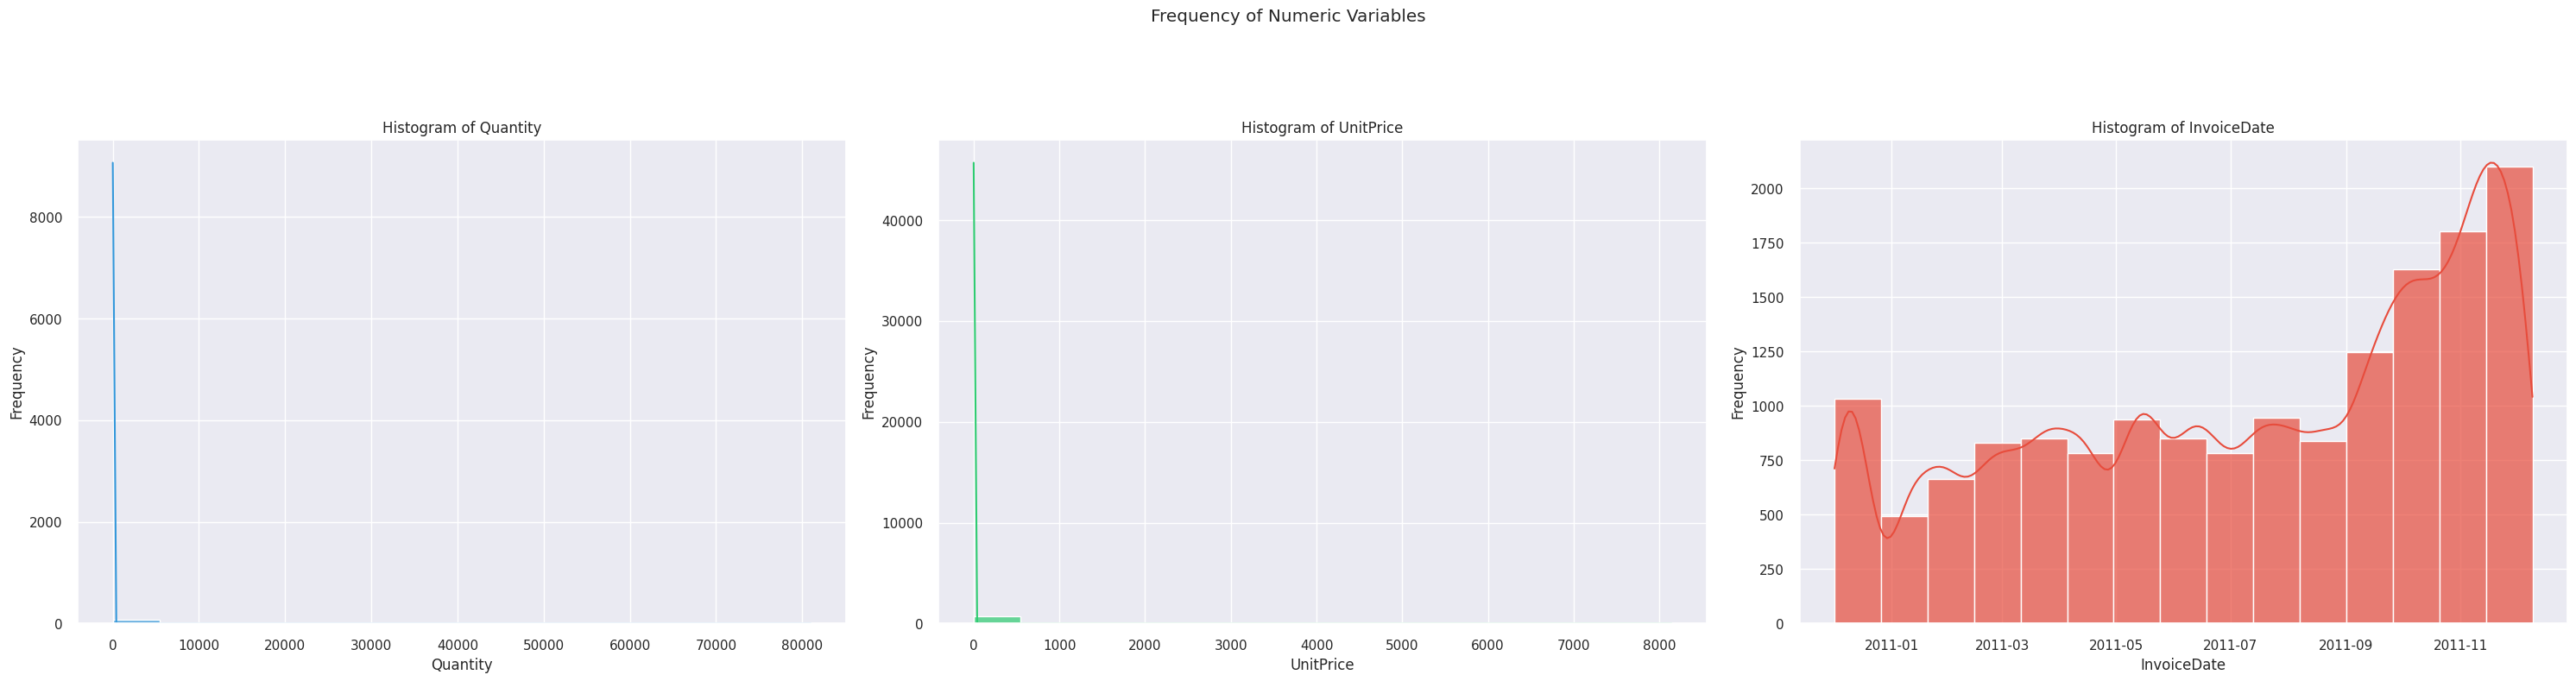

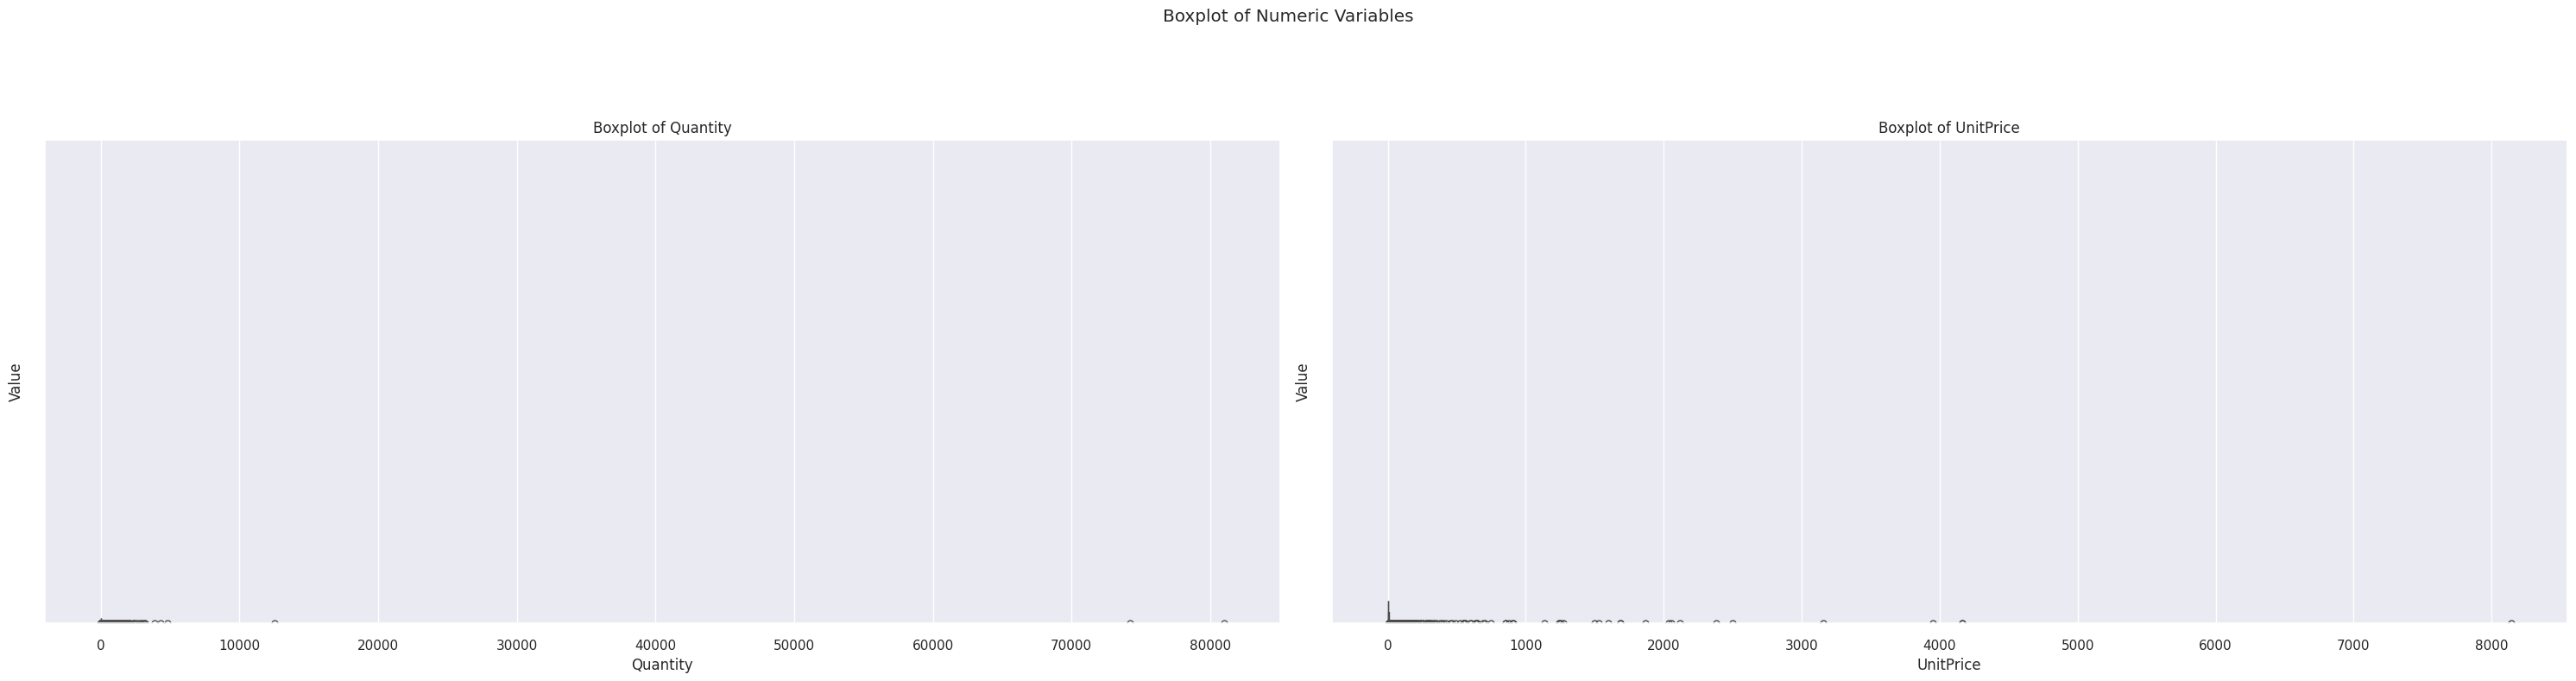

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melhoria no histograma
fig, axes = plt.subplots(1, 3, figsize=(30, 7.5))
colors = ['#3498db', '#2ecc71', '#e74c3c']  # Adicionando cores distintas

for c, ax in enumerate(axes):
    sns.histplot(
        x=transactions[num[c]],
        kde=True,
        stat='frequency',
        bins=15,  # Aumentar o número de bins para maior precisão
        ax=ax,
        color=colors[c],  # Definir cores
        alpha=0.7  # Ajustar a transparência
    )
    ax.set_xlabel(f'{num[c]}')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {num[c]}')
    ax.grid(True)  # Adicionar grid lines para melhorar a leitura

plt.suptitle('Frequency of Numeric Variables', y=1.05)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Melhoria no boxplot
fig, axes = plt.subplots(1, 2, figsize=(30, 7.5))
for c, ax in enumerate(axes):
    sns.boxplot(
        x=transactions[num[c]],
        ax=ax,
        color=colors[c],  # Usar cores distintas
        fliersize=5  # Reduzir o tamanho dos outliers
    )
    ax.set_ylim(0, transactions[num[c]].quantile(0.95))  # Limitar o eixo y para excluir outliers extremos
    ax.set_xlabel(f'{num[c]}')
    ax.set_ylabel('Value')
    ax.set_title(f'Boxplot of {num[c]}')
    ax.grid(True)

plt.suptitle('Boxplot of Numeric Variables', y=1.05)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Como a quantidade de outliers é grande, é importante remover os outliers externos para `Quantity` acima de 10.000 e para `UnitPrice`acima de 3.000.**

In [22]:
transactions.drop(
    transactions.loc[
        (transactions['Quantity'] > 10000) |
        (transactions['UnitPrice'] > 3000)
    ].index,
    inplace=True
)
transactions.shape

(392724, 8)

Verificar novamente as distribuições

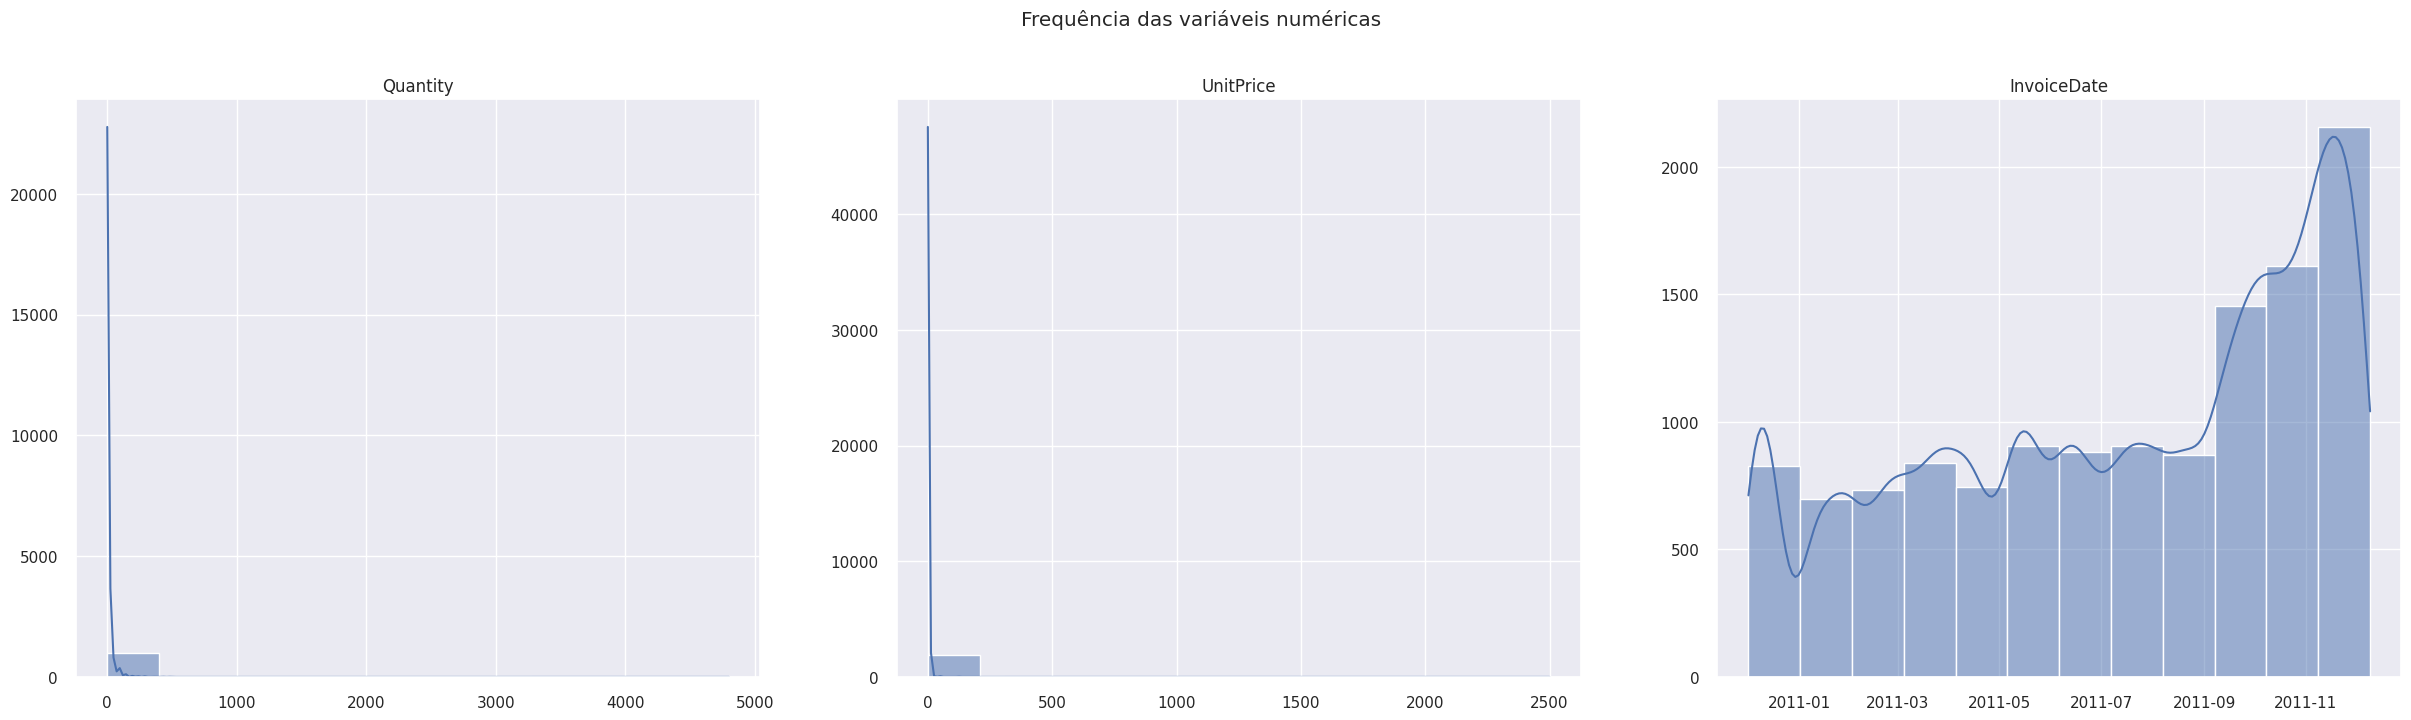

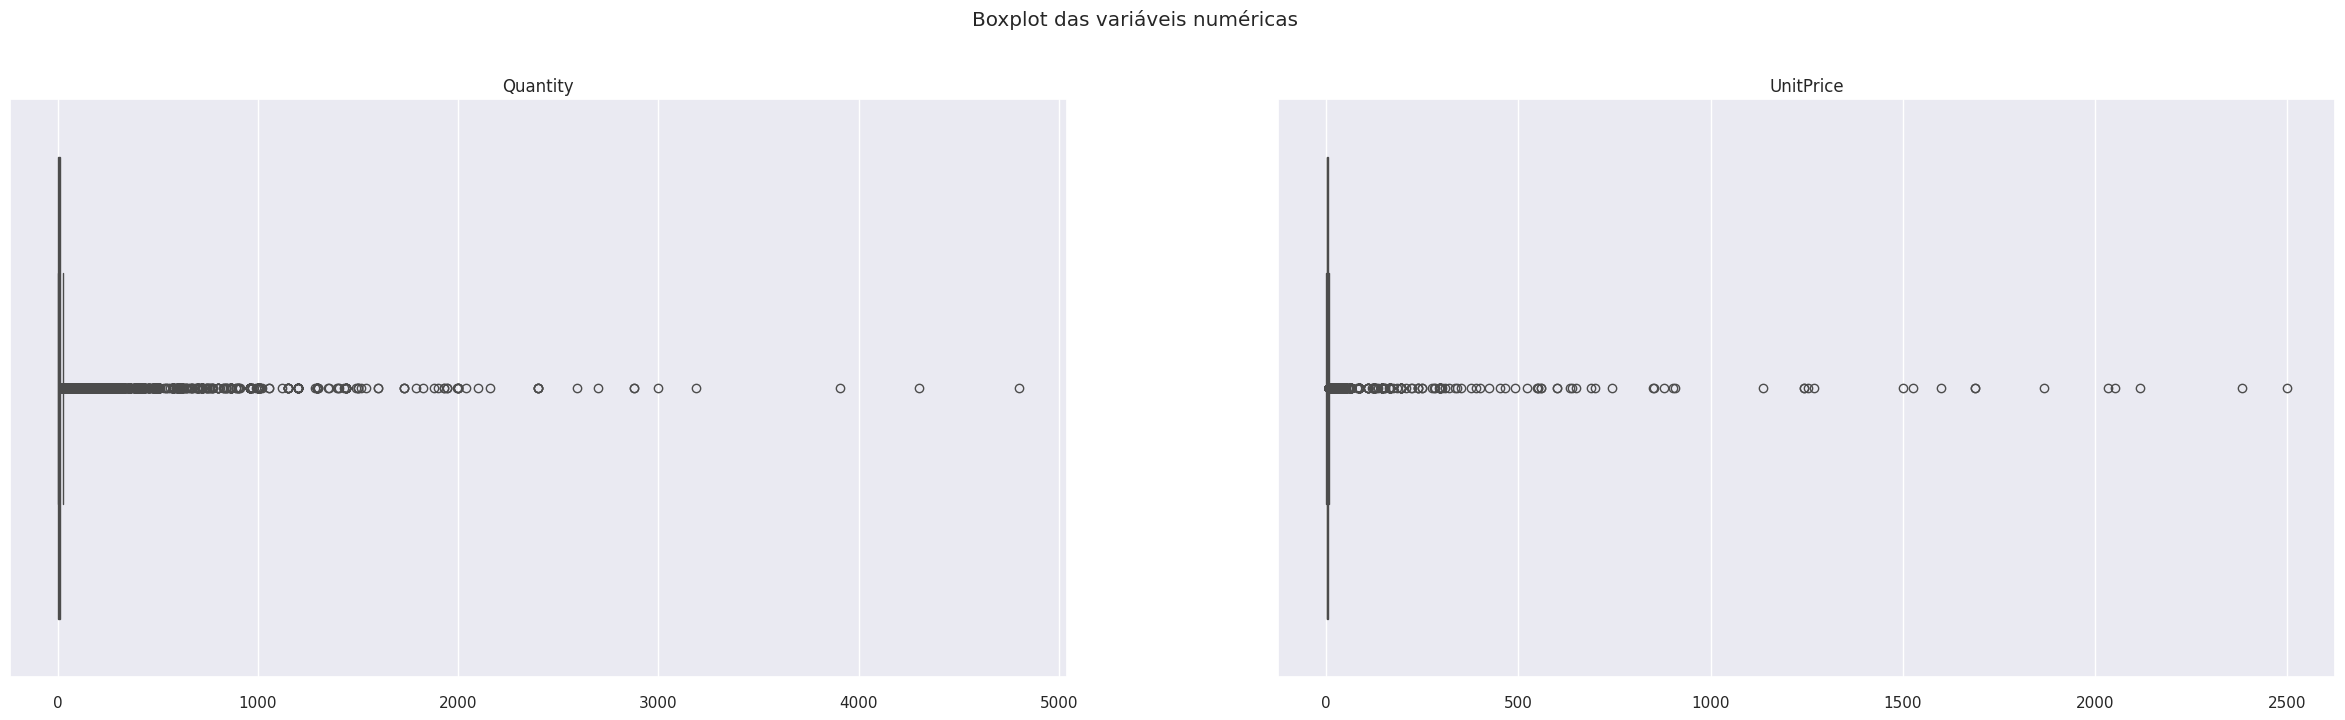

In [28]:
fig, axes = plt.subplots(1,3, figsize=(30,7.5))
for c, ax in enumerate(axes.flatten()):
    sns.histplot(
        x=transactions[num[c]],
        kde=True,
        stat='frequency',
        bins=12,
        ax=ax
    ).set(
        xlabel='',
        ylabel='',
        title=num[c]
    )

plt.suptitle(t='Frequência das variáveis numéricas', y=1)
plt.show()
print('')
fig, axes = plt.subplots(1,2, figsize=(30,7.5))
for c, ax in enumerate(axes.flatten()):
    sns.boxplot(
        x=transactions[num[c]],
        ax=ax
    ).set(
        xlabel='',
        ylabel='',
        title=num[c]
    )

plt.suptitle(t='Boxplot das variáveis numéricas', y=1)
plt.show()

Ainda existem outliers significativos, mas os dados estão melhor tratados para criação do modelo.

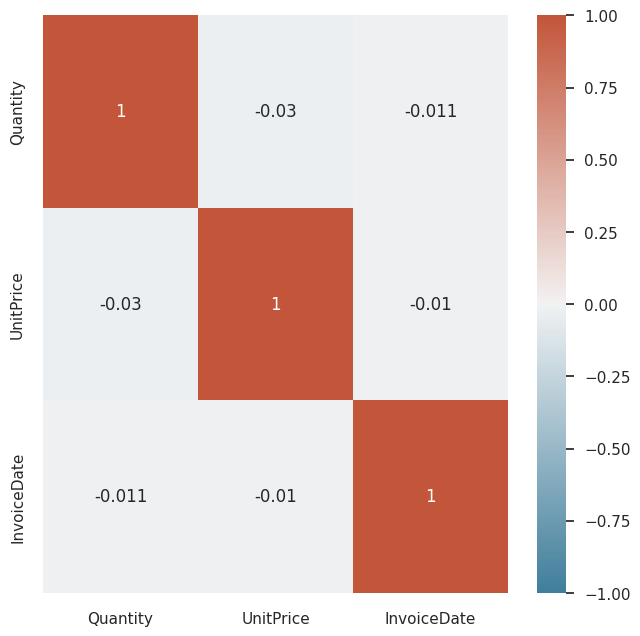

In [25]:
plt.figure(figsize= (7.5, 7.5))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(data = transactions[num].corr(),
            cmap = cmap,
            vmin = -1,
            annot=True)

plt.show()

A correlação entre o Preço unitário e a quantidade é muito baixa, sendo as duas variáveis relevantes para o modelo. Vamos calcular agora o valor total da compra.

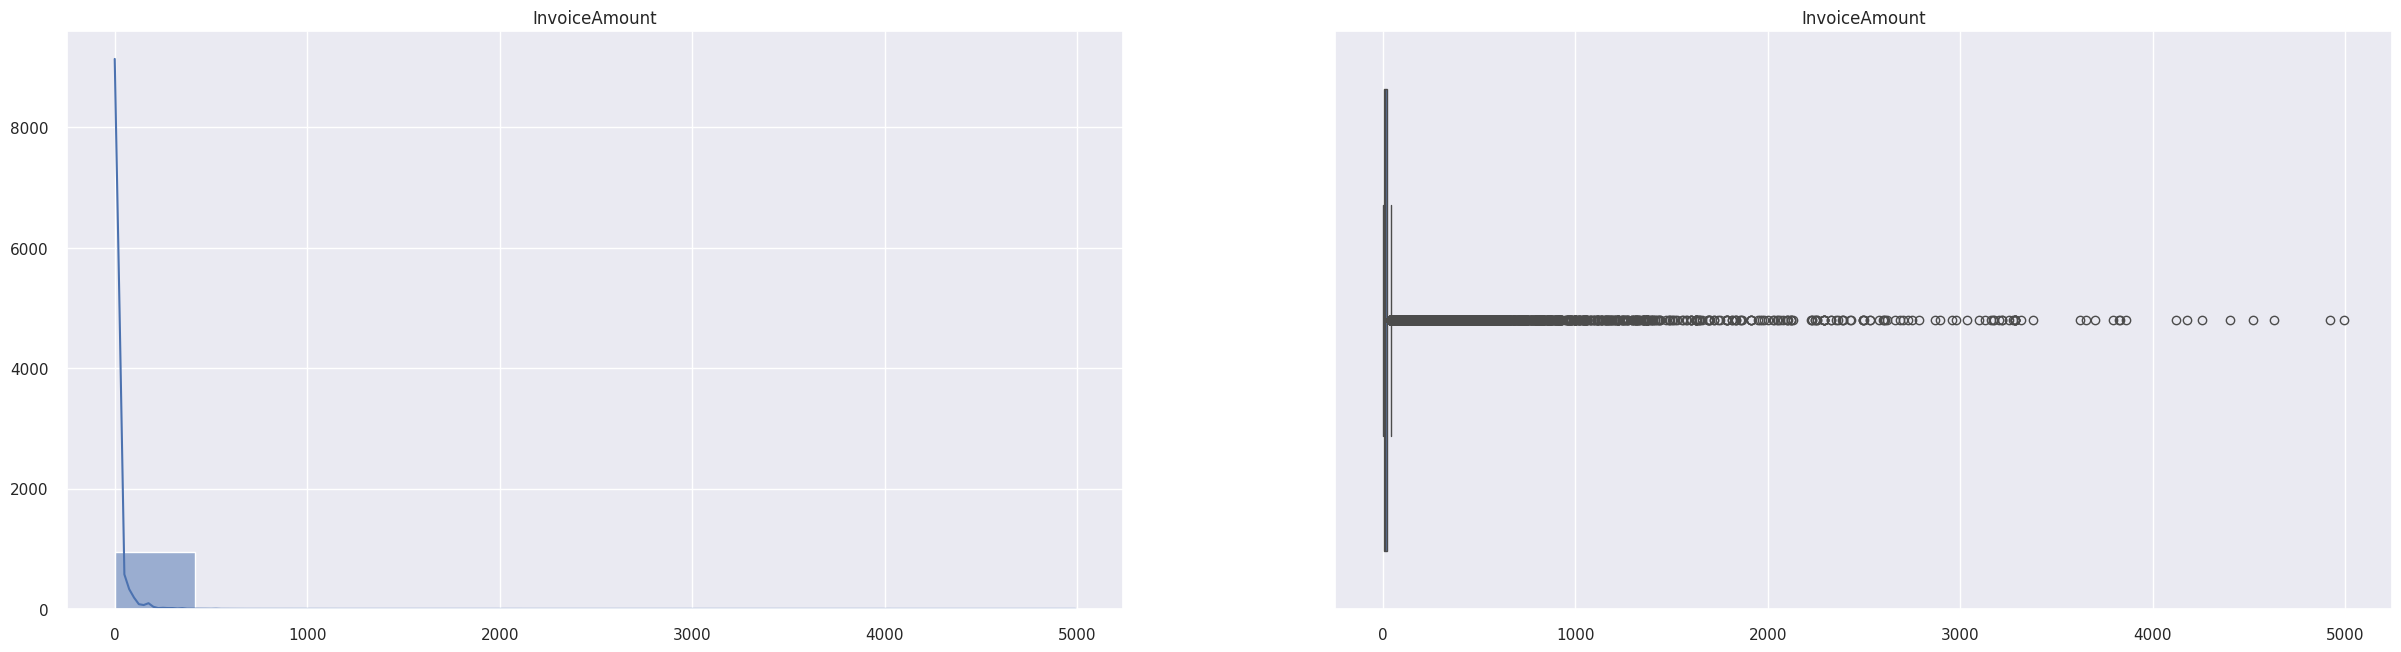

In [29]:
transactions['InvoiceAmount'] = transactions['UnitPrice'] * transactions['Quantity']

fig, axes = plt.subplots(1,2, figsize=(30,7.5))

sns.histplot(
    x=transactions['InvoiceAmount'],
    kde=True,
    stat='frequency',
    bins=12,
    ax = axes[0]
).set(
    xlabel='',
    ylabel='',
    title='InvoiceAmount'
)
sns.boxplot(
    x=transactions['InvoiceAmount'],
    ax=axes[1]
).set(
    xlabel='',
    ylabel='',
    title='InvoiceAmount'
)


plt.show()

Como neste caso também existem alguns outliers, serão removidas as entradas com valor de compra superior a $5.000,00

In [27]:
transactions.drop(
    transactions.loc[
        transactions['InvoiceAmount'] > 5000
    ].index,
    inplace=True
)
transactions.shape

(392720, 9)

#### Dados categóricos

In [30]:
top_10_countries = transactions[
    ['Country', 'InvoiceAmount']
].groupby(
    'Country'
).sum(
    'InvoiceAmount'
).sort_values(
    'InvoiceAmount',
    ascending=False
).head(10).reset_index()['Country'].to_list()
top_10_prod = transactions[
    ['StockCode', 'InvoiceAmount']
].groupby(
    'StockCode'
).sum(
    'InvoiceAmount'
).sort_values(
    'InvoiceAmount',
    ascending=False
).head(10).reset_index()['StockCode'].to_list()

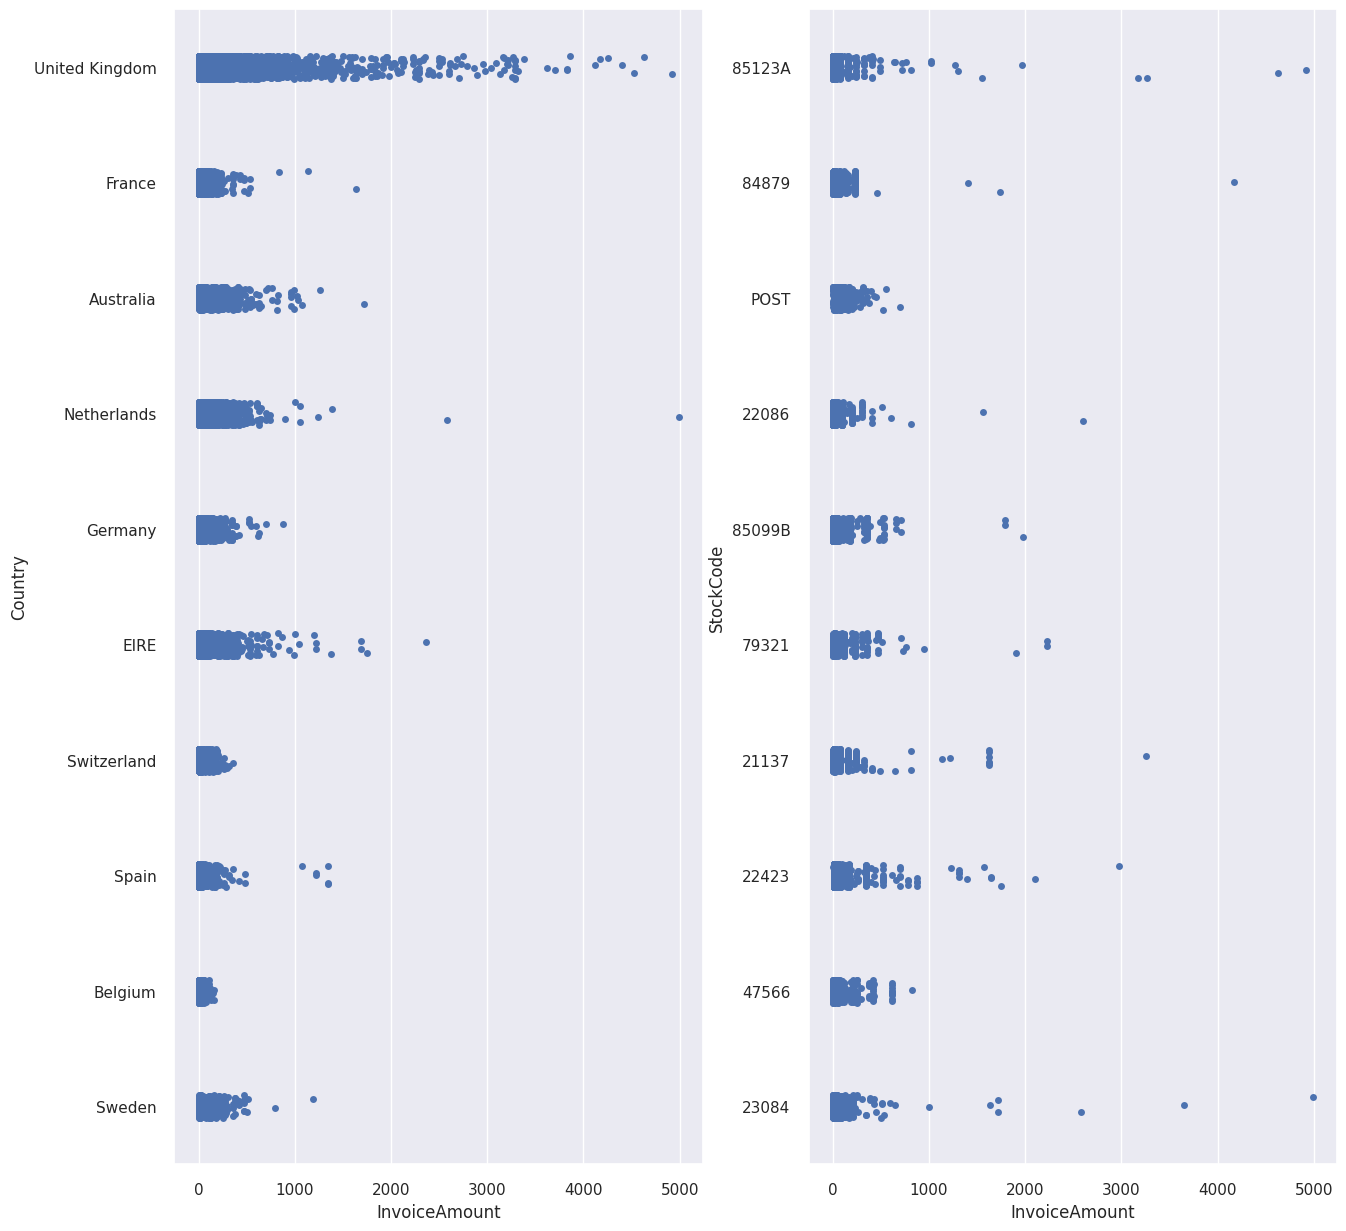

In [31]:
fig, axes = plt.subplots(1,2, figsize=(15,15))
sns.stripplot(
    data=transactions.loc[transactions['Country'].isin(top_10_countries)],
    x='InvoiceAmount',
    y='Country',
    ax=axes[0]
)
sns.stripplot(
    data=transactions.loc[transactions['StockCode'].isin(top_10_prod)],
    x='InvoiceAmount',
    y='StockCode',
    ax=axes[1]
)
plt.show()

### Cálculo do RFM

- R (Recency): dias desde a última compra
- F (Frequency): quantidade de compras realizadas
- M (Monetary): valor médio gasto em compras pelo cliente

In [32]:
customer_transactions = transactions.groupby(
    ['CustomerID', 'InvoiceNo']
).agg(
    LastPurchase = ('InvoiceDate', 'max'),
    TotalPurchase = ('InvoiceAmount', 'sum')
).reset_index()

In [33]:
last_transaction = transactions.InvoiceDate.max()
customer_rfm = customer_transactions.groupby(
    'CustomerID'
).agg(
    Recency = ('LastPurchase', lambda x: (last_transaction - x.max()).days),
    Frequency = ('InvoiceNo', 'count'),
    MeanTicket = ('TotalPurchase', 'mean')
).reset_index()

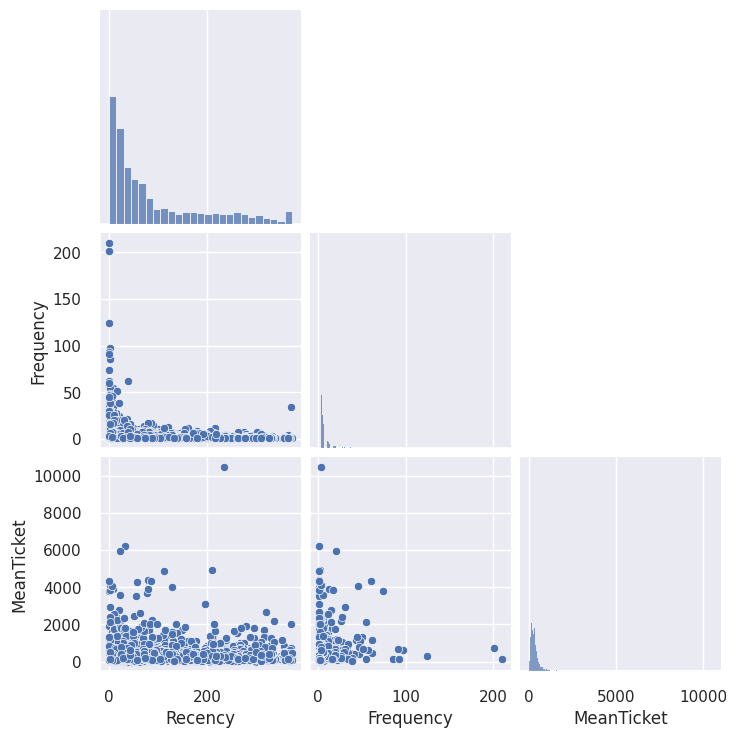

In [34]:
x = customer_rfm.drop(columns='CustomerID')

sns.pairplot(x, corner=True)

### Normalização dos dados

In [35]:
scaler = StandardScaler()
df_scaler = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
describe_df(df_scaler)

,count,mean,std,min,25%,50%,75%,max,pct_nulls
Recency,4337.0,-0.0,1.0,-0.916,-0.746,-0.416,0.495,2.816,0.0
Frequency,4337.0,-0.0,1.0,-0.425,-0.425,-0.295,0.094,26.703,0.0
MeanTicket,4337.0,-0.0,1.0,-0.872,-0.464,-0.197,0.121,23.612,0.0


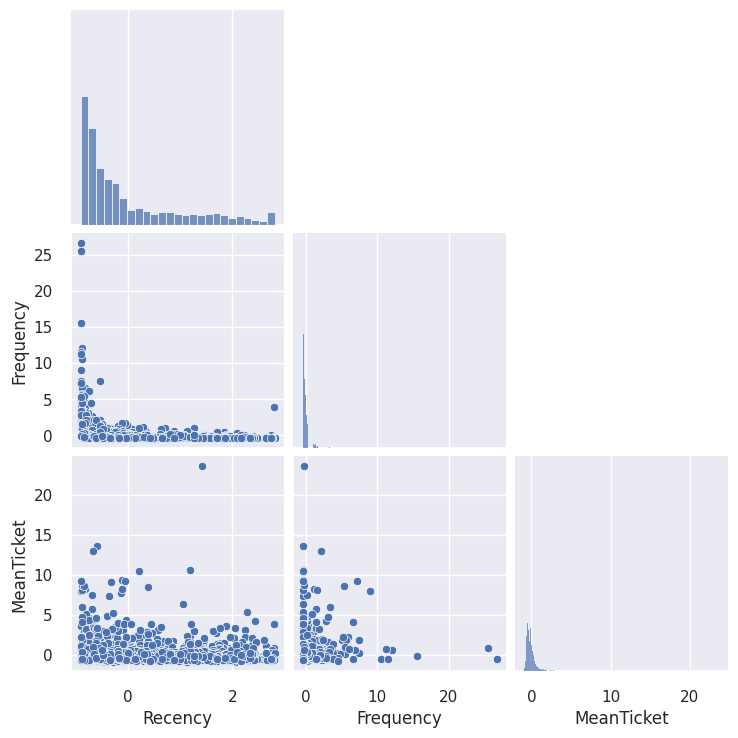

In [36]:
sns.pairplot(df_scaler, corner=True)

### Segmentação dos clientes

Utilizando KMEANS primeiro é necessário determinar a quantidade de clusters ideal.

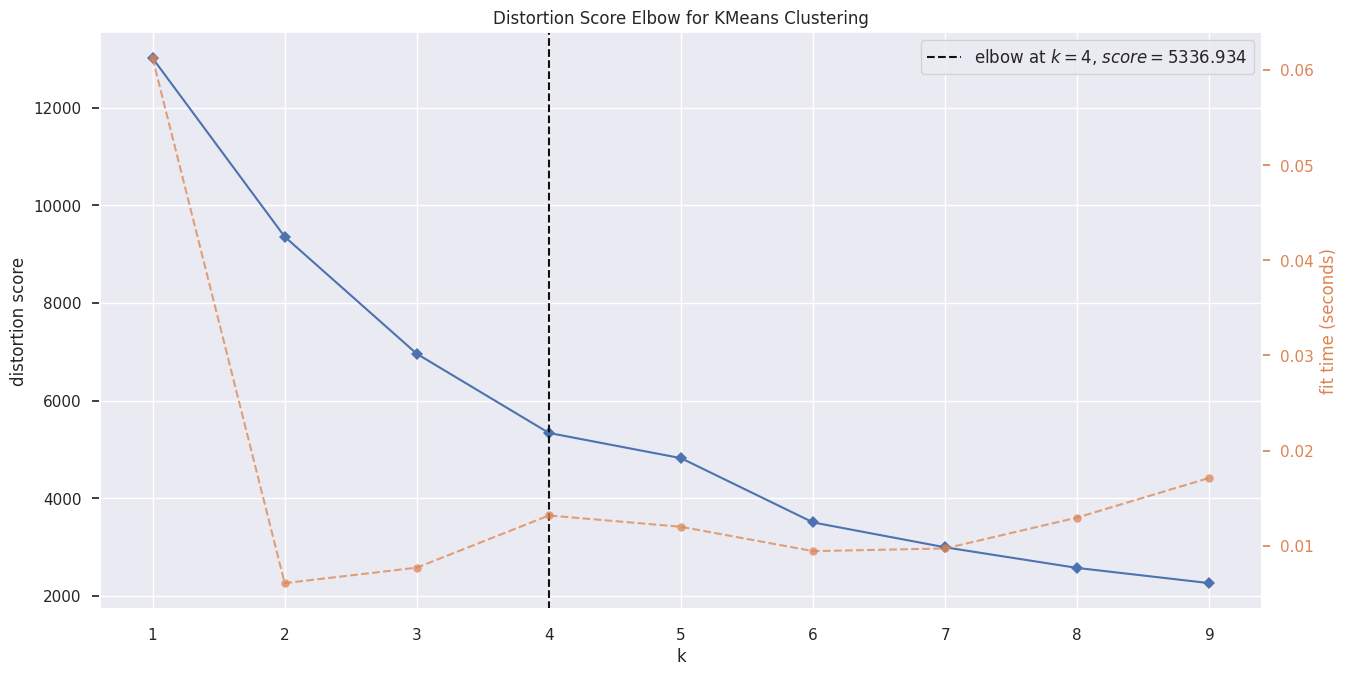

In [37]:
plt.figure(figsize=(15,7.5))
kelbow_visualizer(KMeans(n_init='auto'), df_scaler, k=(1,10))

plt.show()

Utilizando o método de Elbow, a quantidade ideal de clusters é 4.

In [38]:
km = KMeans(4, n_init='auto')
km.fit(x)

x['cluster'] = km.predict(x)
x['cluster'].value_counts()

,count
cluster,
2,3234
0,969
3,114
1,20


Identificar o percentual que cada cluster representa da base de dados

In [41]:
(x['cluster'].value_counts() / x.shape[0])*100

,count
cluster,
2,74.567674
0,22.342633
3,2.628545
1,0.461148


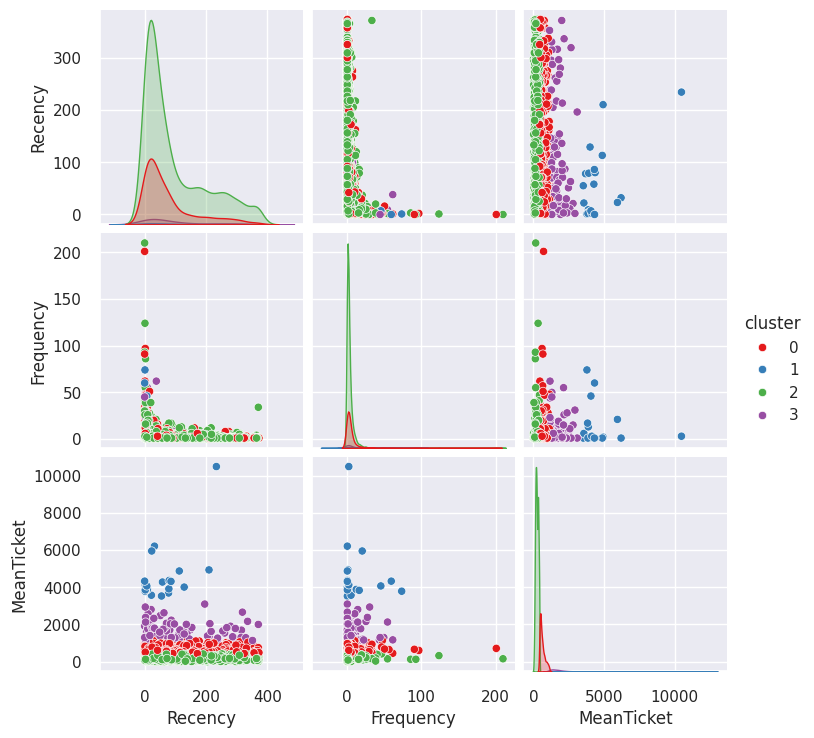

In [42]:
sns.pairplot(x, hue='cluster', palette='Set1')

In [43]:
for c in x['cluster'].unique():
    print(f'Cluster {c}')
    display(x.loc[x['cluster'] == c].describe().T.round(decimals=2))
    print('---------------------\n')

Cluster 0


,count,mean,std,min,25%,50%,75%,max
Recency,969.0,74.24,84.59,0.00,15.00,43.00,93.00,373.00
Frequency,969.0,5.21,9.88,1.00,1.00,3.00,6.00,201.00
MeanTicket,969.0,616.76,176.12,421.74,476.65,558.95,710.61,1136.13
cluster,969.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00


---------------------

Cluster 3


,count,mean,std,min,25%,50%,75%,max
Recency,114.0,89.77,100.07,0.00,16.25,50.50,125.00,371.0
Frequency,114.0,6.70,11.43,1.00,1.00,2.00,6.00,62.0
MeanTicket,114.0,1654.31,434.69,1141.24,1301.12,1576.08,1855.03,3096.0
cluster,114.0,3.00,0.00,3.00,3.00,3.00,3.00,3.0


---------------------

Cluster 2


,count,mean,std,min,25%,50%,75%,max
Recency,3234.0,96.97,103.72,0.0,17.00,52.00,158.00,373.00
Frequency,3234.0,3.85,6.48,1.0,1.00,2.00,4.00,210.00
MeanTicket,3234.0,233.10,99.29,2.9,154.44,225.48,315.64,436.18
cluster,3234.0,2.00,0.00,2.0,2.00,2.00,2.00,2.00


---------------------

Cluster 1


,count,mean,std,min,25%,50%,75%,max
Recency,20.0,61.15,68.12,0.00,6.00,43.5,81.50,234.00
Frequency,20.0,12.90,21.57,1.00,1.00,2.5,14.00,74.00
MeanTicket,20.0,4600.84,1559.28,3528.34,3854.06,4100.9,4493.54,10485.17
cluster,20.0,1.00,0.00,1.00,1.00,1.0,1.00,1.00


---------------------



## Análise dos clusters obtidos

# Análise dos Clusters

A análise dos clusters ajuda a identificar diferentes grupos de clientes com comportamentos distintos, baseados nas variáveis de **Recency** (tempo desde a última compra), **Frequency** (frequência de compras) e **MeanTicket** (valor médio gasto por compra). Cada cluster representa um grupo com características semelhantes. Vamos analisar cada um dos clusters:

---

## **Cluster 1 (Grupo de Alta Frequência e Alto Gasto)**

- **Recency**: Média de 61,15 dias (desvio padrão: 68,12). O valor mínimo é de 0 dias, e o máximo de 234 dias. Isso sugere que os clientes neste cluster realizaram suas últimas compras há um tempo razoável, mas ainda dentro de uma janela de engajamento relevante.
- **Frequency**: Média de 12,90 (desvio padrão: 21,57). O número mínimo de compras foi de 1, mas houve clientes com até 74 compras, indicando uma grande variação no comportamento de compra.
- **MeanTicket**: Média de R$4600,84 (desvio padrão: 1559,28). O gasto médio é muito alto em comparação com outros clusters, o que sugere que esses clientes são de grande valor. O máximo chega a R$10.485,17, o que evidencia a presença de compradores de alto poder aquisitivo.
- **Cluster**: O cluster é composto por 20 clientes.

**Conclusão**: Esse cluster representa os clientes mais valiosos, com alta frequência de compras e altos valores médios por ticket. Eles provavelmente são o principal foco das estratégias de retenção e programas de fidelidade.

---

## **Cluster 2 (Grupo de Média Recorrência e Baixo Gasto)**

- **Recency**: Média de 96,97 dias (desvio padrão: 103,72), o que indica que estes clientes demoram mais a realizar uma nova compra em relação ao Cluster 1. Alguns deles fizeram sua última compra há até 373 dias.
- **Frequency**: Média de 3,85 (desvio padrão: 6,48). Embora a frequência seja significativamente menor do que no Cluster 1, ainda assim esses clientes fazem compras de forma consistente.
- **MeanTicket**: Média de R$233,10 (desvio padrão: 99,29). Esse é o valor médio gasto por compra mais baixo entre os clusters, indicando que esses clientes não gastam muito por compra.
- **Cluster**: O cluster é composto por 3234 clientes, sendo o maior cluster da análise.

**Conclusão**: Este cluster representa clientes de valor relativamente baixo em termos de gasto por compra, mas que têm uma frequência razoável. Embora não sejam grandes gastadores, o volume de clientes nesse grupo pode ser relevante para as receitas da empresa. Estratégias para aumentar o ticket médio podem ser interessantes aqui.

---

## **Cluster 3 (Grupo de Alta Recorrência e Gasto Moderado)**

- **Recency**: Média de 89,77 dias (desvio padrão: 100,07), um valor semelhante ao do Cluster 2, sugerindo que esses clientes também demoram um pouco para fazer novas compras.
- **Frequency**: Média de 6,70 (desvio padrão: 11,43). Esses clientes fazem mais compras do que os clientes do Cluster 2, mas ainda menos do que os do Cluster 1.
- **MeanTicket**: Média de R$1654,31 (desvio padrão: 434,69). O valor médio gasto por compra é significativamente maior do que o do Cluster 2, mas ainda abaixo do Cluster 1.
- **Cluster**: O cluster é composto por 114 clientes.

**Conclusão**: Esse cluster representa clientes que gastam moderadamente, mas fazem compras mais frequentes do que os clientes do Cluster 2. Eles têm um bom valor para a empresa e podem ser incentivados a aumentar sua frequência de compras ou seu ticket médio.

---

## **Cluster 0 (Grupo de Baixa Recorrência e Baixo Gasto)**

- **Recency**: Média de 74,24 dias (desvio padrão: 84,59). Os clientes neste cluster têm um tempo moderado desde sua última compra, sendo alguns muito recentes e outros muito antigos.
- **Frequency**: Média de 5,21 (desvio padrão: 9,88). Este grupo de clientes também apresenta uma baixa frequência de compras, com a maioria deles realizando apenas uma ou poucas compras.
- **MeanTicket**: Média de R$616,76 (desvio padrão: 176,12). O valor médio por ticket é menor do que o dos clusters mais valiosos, sugerindo que esse grupo gasta menos em suas compras.
- **Cluster**: O cluster é composto por 969 clientes.

**Conclusão**: Esse cluster é de clientes com comportamento de baixa frequência e ticket médio moderado. Eles podem estar mais propensos a abandonar a marca, então estratégias de reengajamento ou promoções específicas podem ser necessárias para aumentar sua atividade.

---

# Resumo Geral

- **Cluster 1** contém os clientes mais valiosos em termos de gasto e frequência de compras. Eles são essenciais para a receita e devem ser alvo de estratégias de fidelização.
- **Cluster 2** é o maior em termos de quantidade de clientes, mas com gastos menores. Estratégias para aumentar o ticket médio ou incentivar a frequência de compra podem ser úteis aqui.
- **Cluster 3** mostra um comportamento moderado, com clientes que fazem mais compras e gastam relativamente bem. Estratégias que aumentem a recorrência ou o ticket médio desses clientes podem ser eficazes.
- **Cluster 0** contém uma combinação de clientes de baixo valor e recorrência, sendo um grupo em risco de abandono. Reengajamento pode ser uma prioridade para essa segmentação.

Cada cluster tem características distintas que podem ser aproveitadas para direcionar campanhas de marketing específicas, personalizadas para aumentar o valor do cliente e a retenção.
